<div class="alert alert-block alert-info">
    <b>NOTE</b>
    this blog post can be run as a jupyter notebook. I re-ordered the cells to make it easier to read; to re-produce all the plots see instructions at the end of the post.
</div>

## Background

_"Diverse optimization"_ has been a popular topic in machine learning conferences
for a few years now, particularly in the "AI for drug discovery" sub-field.
In this context, the goal of "optimization" algorithms is to suggest
promising drug candidates,
where "promising" means maximizing one (or more) objective functions.
An example of an objective function could be a docking score
(an approximate simulation of the interactions between a protein and a molecule).
"Diverse" optimization further requires that an algorithm produce multiple
distinct candidate solutions.
This is typically desired when the objective functions don't fully capture
everything we want (for example, a drug candidate also having low toxicity).
The hope is that a diverse set of candidates will have a higher chance of
one useful candidate compared to a non-diverse sets.

<!-- TEASER_END -->
Consider the popular single-objective noiseless setting
with objective function $f$.
Assume that you run an algorithm and produce a set of candidates
$\{x_1,\ldots,x_N\}$ (sorted in decreasing order of $f$).
A common way to score the algorithm is to report the metrics:

1. **Top-k average** $\frac{1}{k}\sum_{i=1}^k f(x_i)$. Higher is better.
2. **Top-k diversity** $\frac{1}{k(k-1)}\sum_{i,j\leq k, i\neq j} d(x_i,x_j)$ (where $d$ is some kind of distance metric like Euclidean distance or Tanimoto distance between molecular fingerprints). Higher is better.

Usually $k$ is set to a reasonably low number (5 or 10).
At first glance these metrics seem reasonable:
a good "diverse optimization" algorithm should ideally produce $k$ points
with high property scores and which are very diverse.

## Top-k diversity can be misleading

The main point I want to convey in this post is that 
it is possible
for an algorithm to have a low top-k diversity despite producing a diverse range of solutions.
To illustrate this, imagine 2 algorithms (A and B) optimizing a toy function $f$ in 1D.
Each algorithm produces the following 50 candidates,
achieving the following top 5 average and diversity 
scores
(using Euclidean distance for the diversity metric).

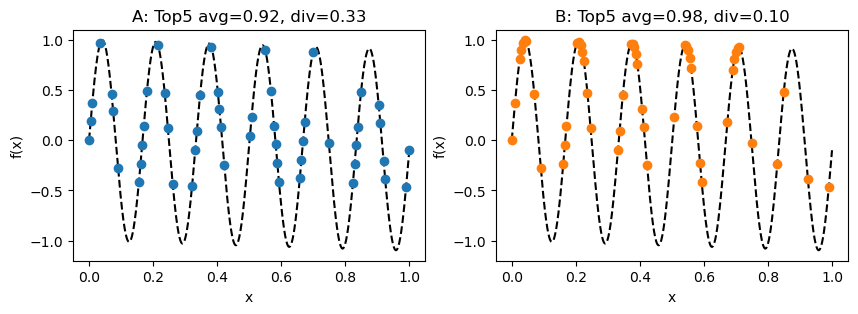

In [9]:
main_plot()

Although algorithm B has a slightly higher top-5 average score, algorithm A
has a much higher top-5 diversity score.
This suggests a trade-off between the two metrics
However, overlaying the candidates and zooming in suggests that
this trade-off is an illusion.

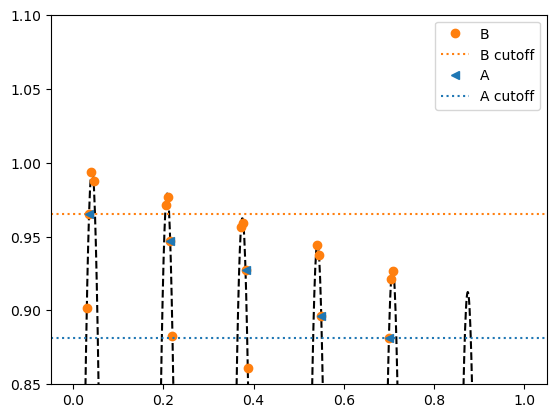

In [10]:
top_solutions_plot()

This plot suggests that algorithm B has performed _strictly better_ than algorithm A,
despite its top-5 diversity being much lower.
Not only has B also found the exact same top-5 solutions as A
(notice the orange circles behind the blue triangles),
it has also found two improved solutions in each mode which are closer to the local optimum.

The large difference in top-5 diversity scores is caused by algorithm B
finding "too many" points in the first two modes of the function,
causing the cutoff for entering its top-5 to be much higher than than of algorithm A.
Although this does make B's top-5 diversity indisputably lower,
I argue that it does not make sense to describe B's overall set of solutions found as
"less diverse" than A's.
Therefore, I see the top-k diversity metric itself as the problem.

## Does this make top-5 diversity a bad metric?

Short answer: yes.

Long answer: if you are considering the top-k solutions of two algorithms and want to know whether they are diverse, then this is a sensible metric. However, the example above shows that it does not make sense to use top-k diversity values to make conclusions about the overall diversity of points found by an algorithm. This is how many machine learning papers interpret this metric, and I think they should stop doing that.

If you did not find the example above convincing, consider the following thoughts:

- One could improve algorithm B's top-5 diversity score by _deleting_ some of its secondary solutions around each local maximum. Does it make sense for algorithm B to be _penalized_ for finding more high-scoring points?
- Imagine two restaurants C and D, where C's menu is a superset of D's ($D\subset C$) and every single dish in from D is better at restaurant C. Would it make sense to call D a more "diverse" restaurant just because C's very best dishes are all from the same category?
- The best way to achieve a high top-5 diversity is to find one point in each mode, then immediately stop exploring that mode in case you find additional points which lower diversity. Of course, diverse optimization algorithms should _eventually_ stop exploring individual modes. Should it necessarily be after 1 point though?

## What should we do instead?

I don't have a perfect answer for this. To avoid a scenario like the one above,
I think diversity metrics would need to satisfy a _monotonicity_ property:
that adding additional points to the solution set does not make the diversity
score any worse. For example, given a set of points

$$S=\big\{(x, y)\big\}_{i=1}^N$$

one approach to making a monotonic metric is to
extract a set of points which are high-performing ($y$ value above some cutoff)
and diverse (every point is at least a specified distance away from every other point).
Mathematically, such a set would satisfy.

$$S^+ = \{(x,y) | (x,y)\in S, y \geq c_1, d(x,x') \geq c_2 \forall (x',y')\neq(x,y)\}$$

The following plot illustrates this for algorithms A and B from above,
using $c_1=0.9$ and $c_2=0.05$.

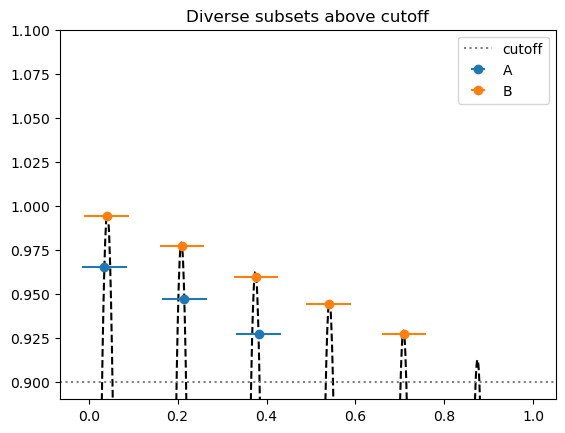

In [11]:
uniform_cutoff_plot()

One could, for example, use the sizes of these sets as a metric.
This approach has the disadvantage of introducing some extra hyperparameters
($c_1$ and $c_2$), but I could imagine these parameters being known for many
practical problems in fields like drug discovery.

At the very least, this should inspire researchers to look into better metrics!

## Reproducing results from this notebook

First, run all cells below. Then, run all cells above.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(0)

In [2]:
def f(x):
    return np.sin(x  * 12 * np.pi) - 0.1 * x

x = np.linspace(0, 1, 1000)  # canonical array for plotting

In [3]:
# (these locations were all hard-coded)
_some_good_points = [
    0.035,
    0.215,
    0.382,
    0.55,
    0.70,
]
_extra_good_points = [v+offset for offset in np.linspace(-1e-2, 1e-2, 5) for v in _some_good_points]
_some_ok_points = [0.        , 0.00502513, 0.01005025, 0.07035176, 0.07537688,
       0.08040201, 0.08542714, 0.09045226, 0.09547739, 0.15577889,
       0.16080402, 0.16582915, 0.17085427, 0.1758794 , 0.18090452,
       0.2361809 , 0.24120603, 0.24623116, 0.25125628, 0.25628141,
       0.26130653, 0.32160804, 0.32663317, 0.33165829, 0.33668342,
       0.34170854, 0.34673367, 0.40201005, 0.40703518, 0.4120603 ,
       0.41708543, 0.42211055, 0.42713568, 0.49246231, 0.49748744,
       0.50251256, 0.50753769, 0.51256281, 0.5678392 , 0.57286432,
       0.57788945, 0.58291457, 0.5879397 , 0.59296482, 0.65829146,
       0.66331658, 0.66834171, 0.67336683, 0.67839196, 0.73869347,
       0.74371859, 0.74874372, 0.75376884, 0.75879397, 0.8241206 ,
       0.82914573, 0.83417085, 0.83919598, 0.84422111, 0.84924623,
       0.90452261, 0.90954774, 0.91457286, 0.91959799, 0.92462312,
       0.98994975, 0.99497487, 1.        ]
random.shuffle(_some_ok_points)
_some_bad_points = [0.11055276, 0.12060302, 0.13065327, 0.14070352, 0.28140704,
       0.29145729, 0.30150754, 0.44221106, 0.45226131, 0.46231156,
       0.47236181, 0.6080402 , 0.61809045, 0.6281407 , 0.63819095,
       0.77386935, 0.7839196 , 0.79396985, 0.8040201 , 0.93969849,
       0.94974874, 0.95979899, 0.96984925]
random.shuffle(_some_bad_points)

# Make actual point sets
N = 50
x_bad = np.asarray(_some_bad_points + _some_ok_points)[:N]
x_ok = np.asarray(_some_good_points + _some_ok_points + _some_bad_points)[:N]
x_good = np.asarray(_extra_good_points + _some_ok_points + _some_bad_points)[:N]
set_name_tuples = [
    # (x_bad, "A", "bad"),
    (x_ok, "A", "ok"),
    (x_good, "B", "best"),
]

In [4]:
def _get_topk(x, y, k=5):
    argsort = np.argsort(-y)[:k]
    return x[argsort], y[argsort]

def topk_avg(x, y, k=5):
    return np.mean(np.sort(y)[-k:])

def topk_div(x, y, k=5):
    topk_x = x[np.argsort(-y)[:k]]
    del x, y
    div_sum = 0.0
    div_count = 0
    for i in range(k):
        for j in range(i+1, k):
            div_sum += float(abs(topk_x[i] - topk_x[j]))
            div_count += 1
    return div_sum / div_count

In [5]:
def main_plot():
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)
    colors = ["tab:blue", "tab:orange"]
    for i, t in enumerate(set_name_tuples):
        plt.sca(axes[i])
        x_i = t[0]
        y_i = f(x_i)
        plt.plot(x, f(x), "k--")
        plt.plot(x_i, y_i, "o", color=colors[i])
        _avg = topk_avg(x_i, y_i)
        _div = topk_div(x_i, y_i)
        plt.title(f"{t[1]}: Top5 avg={_avg:.2f}, div={_div:.2f}")
        plt.xlabel("x")
        plt.ylabel("f(x)")
        
    plt.show()

In [6]:
def top_solutions_plot():
    plt.plot(x, f(x), "k--")
    plt.plot(x_good, f(x_good), "o", label="B", color="tab:orange")
    plt.axhline(np.sort(f(x_good))[-5], color="tab:orange", linestyle=":", label="B cutoff")
    plt.plot(x_ok, f(x_ok), "<", label="A", color="tab:blue")
    plt.axhline(np.sort(f(x_ok))[-5], color="tab:blue", linestyle=":", label="A cutoff")
    plt.legend()
    plt.ylim(0.85, None)
    plt.show()

In [7]:
def get_diverse_set_above_cutoff(x, y, cutoff):
    xy_pairs = list(zip(x, y))

    # Eliminate points below cutoff
    xy_pairs = [(a, b) for a, b in xy_pairs if b >= cutoff]

    # Iteratively eliminate duplicates
    done = False
    while not done:
        new_xypairs = []
        

In [8]:
def uniform_cutoff_plot():
    cutoff = 0.9
    plt.plot(x, f(x), "k--")
    plt.axhline(cutoff, color="gray", linestyle=":", label="cutoff")
    x_ok_indices = [i for i, v in enumerate(x_ok) if f(v) >= cutoff]
    plt.errorbar(x=x_ok[x_ok_indices], y=f(x_ok[x_ok_indices]), xerr=0.05, linestyle="None", marker="o", color="tab:blue", label="A")
    x_good_indices = [15, 6, 7, 3, 24]
    plt.errorbar(x=x_good[x_good_indices], y=f(x_good[x_good_indices]), xerr=0.05, linestyle="None", marker="o", color="tab:orange", label="B")
    plt.ylim(0.89, None)
    plt.legend()
    plt.title("Diverse subsets above cutoff")
    plt.show()